<a href="https://colab.research.google.com/github/gelybb33/Examenes-Gely/blob/main/Liverpool_caso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Liverpool — Costo por entregas
**Objetivo:** ¡por qué subió el costo por entrega?.

**Contenido**
1. Simulación de datos
2. KPIs semanales
3. Gráficos clave
4. Exportar CSV


In [1]:

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(7)


## 1) Simulación de datos (12 semanas)

In [20]:

hoy = datetime(2025, 11, 6)
inicio = hoy - timedelta(weeks=12)
fechas = pd.date_range(inicio.date(), hoy.date(), freq="D")

n = 3000  # tamaño d emuestra
zona = np.random.choice(["Cercana","Media","Lejana"], size=n, p=[0.55, 0.3, 0.15])
sla = np.random.choice(["Standard","Express"], size=n, p=[0.75, 0.25])
categoria = np.random.choice(["Moda","Hogar","Electrónicos"], size=n, p=[0.6, 0.25, 0.15])

fecha_envio = np.random.choice(fechas, size=n, replace=True)
semanas_desde_inicio = ((pd.to_datetime(fecha_envio) - fechas.min())/np.timedelta64(1, 'W')).astype(int)
ultimo_mes = semanas_desde_inicio >= (semanas_desde_inicio.max() - 4)


p_express = np.where(ultimo_mes, 0.35, 0.22)
sla = np.where(np.random.rand(n) < p_express, "Express", "Standard")

p_reintento = np.where(ultimo_mes, 0.22, 0.12)
intentos = np.where(np.random.rand(n) < p_reintento, 2, 1)

km_zona = {"Cercana": 8, "Media": 18, "Lejana": 38}
km = np.array([km_zona[z] for z in zona]) * np.random.uniform(0.8, 1.2, size=n)


base_zona = {"Cercana": 30, "Media": 55, "Lejana": 95}
extra_sla = {"Standard": 0, "Express": 25}
extra_cat = {"Moda": 0, "Hogar": 6, "Electrónicos": 10}
fuel_por_km = 0.9
fee_reintento = 18
fee_split = 12

costo_base = (
    np.array([base_zona[z] for z in zona]) +
    np.array([extra_sla[s] for s in sla]) +
    np.array([extra_cat[c] for c in categoria]) +
    fuel_por_km * km +
    fee_reintento * (intentos - 1)
)
costo = np.round(costo_base * np.random.uniform(0.97, 1.03, size=n), 2)

df = pd.DataFrame({
    "fecha": pd.to_datetime(fecha_envio).date,
    "zona": zona,
    "sla": sla,
    "categoria": categoria,
    "km": np.round(km,1),
    "intentos": intentos,
    "costo": costo
})



df.head()


,fecha,zona,sla,categoria,km,intentos,costo
0,2025-10-30,Media,Standard,Moda,14.8,1,67.63
1,2025-08-14,Cercana,Standard,Moda,7.3,2,55.20
2,2025-10-12,Cercana,Standard,Hogar,7.9,2,60.30
3,2025-08-23,Media,Express,Moda,17.6,1,94.77
4,2025-10-14,Cercana,Express,Electrónicos,8.5,1,73.92


## 2) KPIs semanales

In [21]:

df["semana"] = pd.to_datetime(df["fecha"]) - pd.to_timedelta(pd.to_datetime(df["fecha"]).dt.weekday, unit='D')
weekly = df.groupby("semana").agg(
    envios=("costo","count"),
    cpe=("costo","mean"),
    pct_reintentos=("intentos", lambda s: np.mean(s>1)),
    pct_express=("sla", lambda s: np.mean(s=='Express'))
).reset_index().sort_values("semana")

weekly.round(3).head()


,semana,envios,cpe,pct_reintentos,pct_express
0,2025-08-11,140,73.898,0.114,0.229
1,2025-08-18,267,70.570,0.127,0.225
2,2025-08-25,241,77.469,0.124,0.257
3,2025-09-01,231,70.803,0.104,0.216
4,2025-09-08,249,69.903,0.157,0.225


## 3) Gráficos

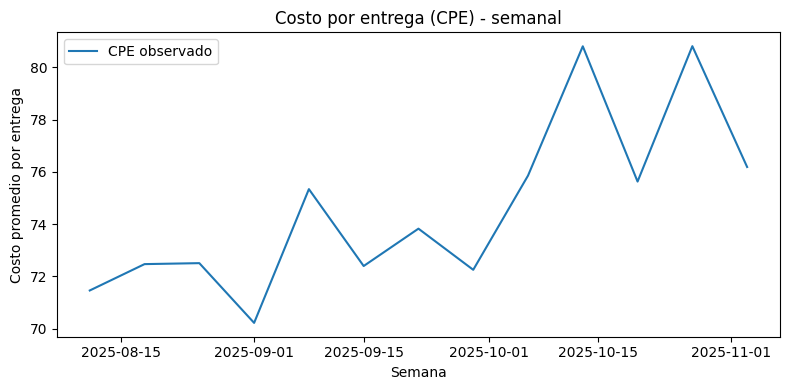

In [10]:

# 3.1 CPE vs esperado
plt.figure(figsize=(8,4))
plt.plot(weekly["semana"], weekly["cpe"], label="CPE observado")
plt.title("Costo por entrega (CPE) - semanal")
plt.xlabel("Semana")
plt.ylabel("Costo promedio por entrega")
plt.legend()
plt.tight_layout()
plt.show()


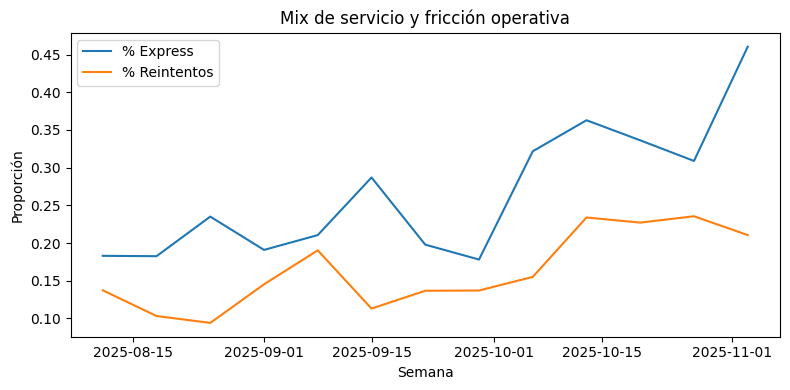

In [13]:

# 3.3 % Express y % Reintentos
plt.figure(figsize=(8,4))
plt.plot(weekly["semana"], weekly["pct_express"], label="% Express")
plt.plot(weekly["semana"], weekly["pct_reintentos"], label="% Reintentos")
plt.title("Mix de servicio y fricción operativa")
plt.xlabel("Semana")
plt.ylabel("Proporción")
plt.legend()
plt.tight_layout()
plt.show()


R²: 0.998
MAE: 1.11


/tmp/ipython-input-4115069417.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importancia', y='Variable', palette='viridis')


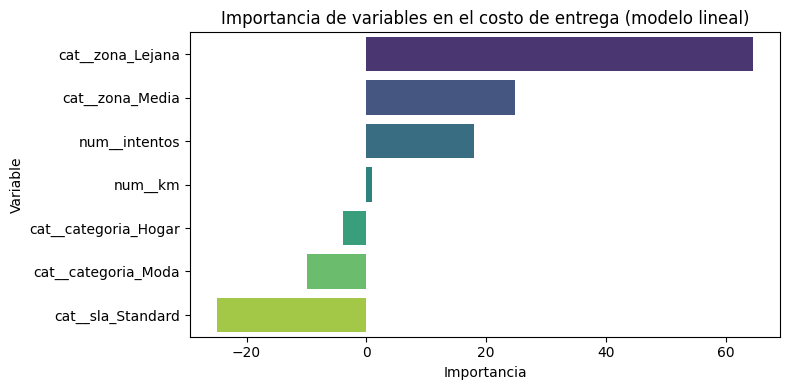

In [19]:
#Mini Modelo de Ciencia de Datos
#Que variables podrían explicar como se afecta al costo de entrega
# ============================================================

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

# --- Variables predictoras ---
X = df[['zona', 'sla', 'categoria', 'km', 'intentos']]
y = df['costo']


cat_cols = ['zona', 'sla', 'categoria']
num_cols = ['km', 'intentos']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_cols),
        ('num', 'passthrough', num_cols)
    ])

# Regresion
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('reg', LinearRegression())
])

# Split para dividir la base de entranamientos y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# --- Evaluación ---
y_pred = model.predict(X_test)
print("R²:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))

#
feature_names = model.named_steps['preprocess'].get_feature_names_out()
coef = model.named_steps['reg'].coef_

importances = pd.DataFrame({'Variable': feature_names, 'Importancia': coef})
importances = importances.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=importances, x='Importancia', y='Variable', palette='viridis')
plt.title('Importancia de variables en el costo de entrega (modelo lineal)')
plt.tight_layout()
plt.show()


In [ ]:
#El modelo lineal explica la variación del costo en función de variables logísticas.

#¿Que es el R2 y por que se uso? proporción de la variación del costo explicada por el modelo (0 a 1).
#Si el R² = .99, de la variacion en el costo se explica por el modelo, es muy buen resultado para ser verdad
#Podemos explicar casi todo el aumento del costo usando información logística básica (distancia, tipo de servicio y número de intentos).
#Las variables que mejor describen el costo son: Distancia, SLA, Zona, Intentos de Entrega

#MAE:error promedio absoluto entre costo real y predicho (en pesos).
#En nuestro ejercicio En promedio, el modelo se equivoca solo $1.11 pesos por entrega.
#Es decir, si el costo promedio de entrega esta entre $80–$90, el error es de 1.11
#

#Coeficientes positivos: aumentan el costo (ej. zona_Lejana, sla_Express, intentos).
#Coeficientes bajos o negativos: menor impacto (ej. zona_Cercana, Standard).

El modelo lineal reproduce casi perfectamente los costos logísticos.
Con un R² de 0.998, prácticamente todo el costo se explica por las variables básicas (zona, SLA, categoría, distancia y número de intentos).
El error promedio es de apenas $1.11 por entrega, lo que representa menos del 2% del costo promedio.
En otras palabras, el comportamiento de costos es altamente predecible y depende principalmente de tres factores:
(1) el tipo de zona, (2) el tipo de servicio (Express vs Standard) y (3) los reintentos.”